# Data Dictionary
1. cap-diameter (m): float number in cm
2. cap-shape (n): bell=b, conical=c, convex=x, flat=f,
sunken=s, spherical=p, others=o
3. cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s,
shiny=h, leathery=l, silky=k, sticky=t,
wrinkled=w, fleshy=e
4. cap-color (n): brown=n, buff=b, gray=g, green=r, pink=p,
purple=u, red=e, white=w, yellow=y, blue=l,
orange=o, black=k
5. does-bruise-bleed (n): bruises-or-bleeding=t,no=f
6. gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e,
sinuate=s, pores=p, none=f, unknown=?
7. gill-spacing (n): close=c, distant=d, none=f
8. gill-color (n): see cap-color + none=f
9. stem-height (m): float number in cm
10. stem-width (m): float number in mm
11. stem-root (n): bulbous=b, swollen=s, club=c, cup=u, equal=e,
rhizomorphs=z, rooted=r
12. stem-surface (n): see cap-surface + none=f
13. stem-color (n): see cap-color + none=f
14. veil-type (n): partial=p, universal=u
15. veil-color (n): see cap-color + none=f
16. has-ring (n): ring=t, none=f
17. ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g,
large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
18. spore-print-color (n): see cap color
19. habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h,
urban=u, waste=w, woods=d
20. season (n): spring=s, summer=u, autumn=a, winter=w

Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


from xgboost.sklearn import XGBClassifier


# Import shap for shapley values
import shap

# JavaScript Important for the interactive charts later on
shap.initjs()

Get data

In [6]:
address = 'https://github.com/hsma-programme/h6_4j_model_optimisation/' + \
                'raw/main/exercise/mushrooms.csv'

df = pd.read_csv(address, sep = ';')

obj_head = list(df.select_dtypes('object')) #select object type columns for one-hot encoding

t_df= df[obj_head] #creates dataframe of object columns

dummies = pd.get_dummies(t_df) #encodes those object columns into separate boolean colummns  

data = dummies.astype(float) #turns bools into float

processed = df.drop(obj_head, axis = 1)
processed_df = processed.join(data)

processed_df


In [7]:

# data.head(
# Class Balance
num_poison = np.sum(processed_df['class_p']==1)
num_nonpoison = np.sum(processed_df['class_e']==1)
print('Mushroom Data')
print('='*46)
print(f'> Data contains {len(processed_df)} entries.')
print(f'> {num_poison} are poisonus')
print(f'> {num_nonpoison} are edible')

# Missing data
def missing_data_percentage(df):
    missing_percentage = df.isnull().mean() * 100
    
    result_df = pd.DataFrame({
        'Column': missing_percentage.index,
        'MissingDataPercentage': missing_percentage.values
    })
    return result_df

missing_data = missing_data_percentage(df)
missing_data
#)

Mushroom Data
> Data contains 61069 entries.
> 33888 are poisonus
> 27181 are edible


,Column,MissingDataPercentage
0,class,0.000000
1,cap-diameter,0.000000
2,cap-shape,0.000000
3,cap-surface,23.121387
4,cap-color,0.000000
5,does-bruise-or-bleed,0.000000
6,gill-attachment,16.184971
7,gill-spacing,41.040462
8,gill-color,0.000000
9,stem-height,0.000000


Test Train Split

In [49]:
X = processed_df.drop('class_p',axis=1) # X = all 'data' except the 'poisonous' column
X = X.drop('class_e',axis=1) # also remove the 'edible' column
y = processed_df['class_p'] # y = 'survived' column from 'data'

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [50]:
X_train.describe().T.to_string()

'                          count       mean        std   min   25%    50%    75%     max\ncap-diameter            39084.0   6.724053   5.213210  0.38  3.48   5.88   8.54   62.34\nstem-height             39084.0   6.570026   3.341233  0.00  4.63   5.95   7.73   33.92\nstem-width              39084.0  12.154023  10.017494  0.00  5.24  10.23  16.55  103.91\ncap-shape_b             39084.0   0.094131   0.292014  0.00  0.00   0.00   0.00    1.00\ncap-shape_c             39084.0   0.030294   0.171397  0.00  0.00   0.00   0.00    1.00\ncap-shape_f             39084.0   0.217787   0.412747  0.00  0.00   0.00   0.00    1.00\ncap-shape_o             39084.0   0.056417   0.230728  0.00  0.00   0.00   0.00    1.00\ncap-shape_p             39084.0   0.042447   0.201609  0.00  0.00   0.00   0.00    1.00\ncap-shape_s             39084.0   0.118156   0.322797  0.00  0.00   0.00   0.00    1.00\ncap-shape_x             39084.0   0.440769   0.496486  0.00  0.00   0.00   1.00    1.00\ncap-surface_d       

Fit a model

In [10]:
model = XGBClassifier(random_state=42)
model = model.fit(X_train,y_train)

Predict values

In [11]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Accuracy

In [12]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train}')
print (f'Accuracy of predicting test data = {accuracy_test}')

Accuracy of predicting training data = 0.9999563328311609
Accuracy of predicting test data = 0.9996725176840451


# SHAP Explainer

In [13]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

 97%|=================== | 14766/15268 [00:18<00:00]       

In [14]:
shap_values_numeric = shap_values.values


In [16]:
# Calculate mean Shap value for each feature in training set
importances = pd.DataFrame()
importances['features'] = X.columns.tolist()
importances['mean_shap_values'] = np.mean(shap_values_numeric, axis=0)

# Calculate mean absolute Shap value for each feature in training set
# This will give us the average importance of each feature
importances['mean_abs_shap_values'] = np.mean(
    np.abs(shap_values_numeric),axis=0)

importances['rank_shap'] = importances['mean_abs_shap_values'].rank(ascending=False).values
importances.sort_values('rank_shap').head()

,features,mean_shap_values,mean_abs_shap_values,rank_shap
2,stem-width,0.134947,1.118059,1.0
81,stem-color_w,-0.030836,0.744926,2.0
39,gill-attachment_p,0.240826,0.681832,3.0
1,stem-height,0.094211,0.555629,4.0
63,stem-surface_g,-0.047020,0.496540,5.0


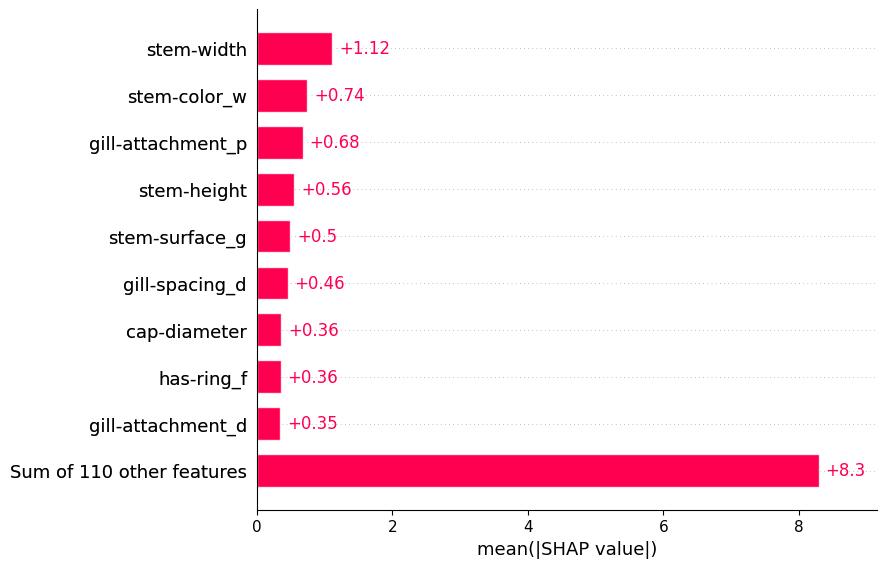

In [17]:
shap.plots.bar(shap_values)

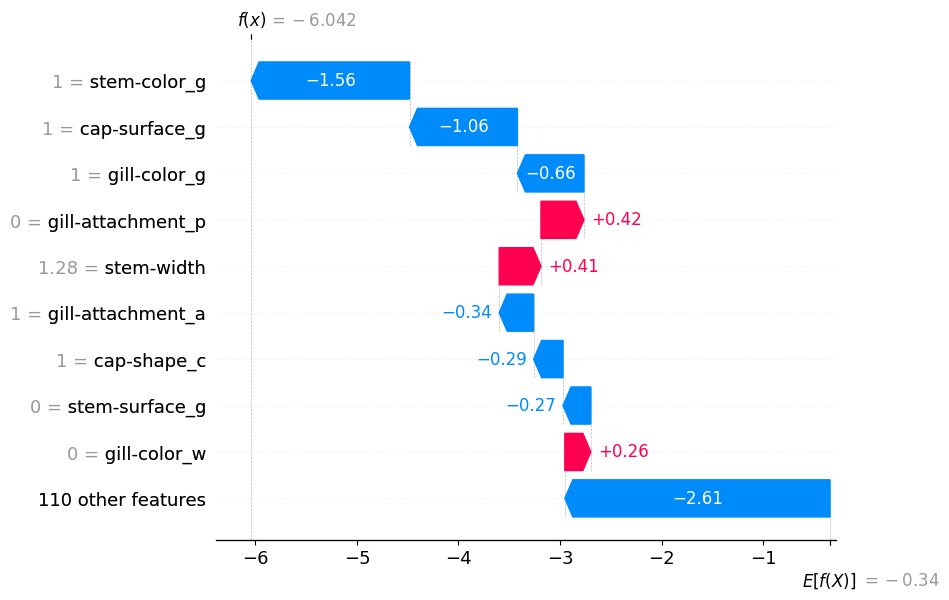

In [18]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [19]:
highest_prob = pd.Series(y_pred_test).sort_values(ascending=False).head(1)
highest_prob

7634    1
dtype: int64

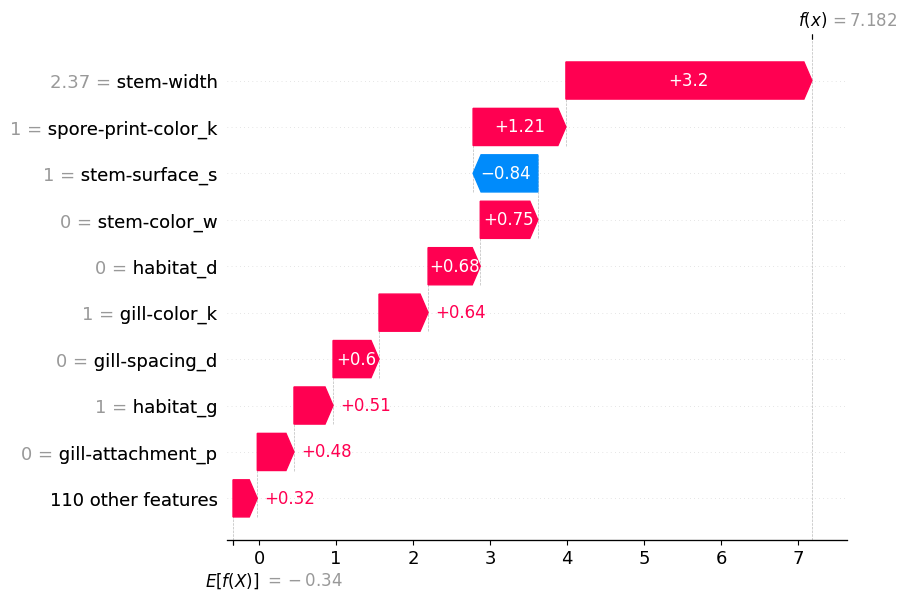

In [20]:
high_prob_index = highest_prob.index[0]
shap.plots.waterfall(shap_values[high_prob_index])

In [43]:
# Multi-model run
## Imports
# Classifier Imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
# SKLearn Imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
# Additional Imports
import matplotlib.pyplot as plt
import pandas as pd

# Class Definition
# Class for model evaluation
class Evaluate():
    # Init
    def __init__(self,data,label_col:str,test_size:float = 0.25,random_state:int = 42):
        self.data = data
        self.label_col = label_col
        self.test_size = test_size
        self.random_state = random_state
        
    # Main Run Method
    def run(self):
        self._split_data()
        self._evaluate_models()
        self._convert_results()

    # Method for splitting data
    def _split_data(self):
        ## Create data splits
        X = self.data.drop(self.label_col,axis=1)
        y = self.data[self.label_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = self.test_size, random_state=self.random_state)
        ## Assign
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    # Method for model metrics
    def _evaluate_model_metrics(self,model, X_train, X_test, y_train, y_test):
        if 'Logistic' in str(model):
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', model)
            ])
        else:
            pipeline = Pipeline([
                ('classifier', model)
            ])
        pipeline.fit(X_train, y_train)
        y_score = pipeline.predict_proba(X_test)[:, 1]
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        specificity = precision_score(y_test, y_pred, pos_label=0)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        return accuracy, precision, recall, specificity, f1, cm, y_score

    # Method for evaluation models
    def _evaluate_models(self):
        ## Define Models
        models = [
            ('Logistic Regression', LogisticRegression(random_state=self.random_state,verbose=0)),
            ('Decision Tree', DecisionTreeClassifier(random_state=self.random_state)),
            ('Random Forest', RandomForestClassifier(random_state=self.random_state,verbose=0)),
            ('XGBoost', XGBClassifier(random_state=self.random_state,verbosity=0)),
            ('AdaBoost', AdaBoostClassifier(random_state=self.random_state)),
            ('CatBoost', CatBoostClassifier(random_state=self.random_state,silent=True)),
            ('LightGBM', LGBMClassifier(random_state=self.random_state,verbose=-1)),
            ('HistGradientBoosting', HistGradientBoostingClassifier(random_state=self.random_state,verbose=0))
        ]
        ## Run model and store results
        results = {}
        for name, model in models:
            accuracy, precision, recall, specificity, f1, cm, y_score = self._evaluate_model_metrics(model, self.X_train, self.X_test, self.y_train, self.y_test)
            results[name] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'Specificity': specificity,
                'F1 Score': f1,
                'Confusion Matrix': cm,
                'y_score': y_score
            }
        ## Return Results
        self.results = results
    
    # Method for converting results into dataframe
    def _convert_results(self):
        self.results_df = pd.DataFrame(self.results).T
        
    # Method for plotting out model metrics
    def plot_metrics(self):
        metrics_df = self.results_df
        plt.figure(figsize=(15, 10))
        # Plot accuracy
        plt.subplot(2, 3, 1)
        metrics_df['Accuracy'].plot(kind='bar', color='skyblue')
        plt.title('Accuracy')
        # Plot precision
        plt.subplot(2, 3, 2)
        metrics_df['Precision'].plot(kind='bar', color='salmon')
        plt.title('Precision')
        # Plot recall
        plt.subplot(2, 3, 3)
        metrics_df['Recall'].plot(kind='bar', color='lightgreen')
        plt.title('Recall')
        # Plot Specificity
        plt.subplot(2, 3, 4)
        metrics_df['Specificity'].plot(kind='bar', color='plum')
        plt.title('Specificity')
        # Plot F1 score
        plt.subplot(2, 3, 5)
        metrics_df['F1 Score'].plot(kind='bar', color='red')
        plt.title('F1 Score')
        # Display
        plt.tight_layout()
        plt.show()
        
    # Method for plotting out ROC
    def plot_roc(self):
        plt.figure(figsize=(10, 8))
        for model in self.results.keys():
            y_score = self.results[model]['y_score']
            fpr, tpr, _ = roc_curve(self.y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{model} (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    # Method for plotting out confusion matrix
    def plot_confusion_matrix(self):
        fig, axes = plt.subplots(4, 2, figsize=(15, 20))
        for i, model in enumerate(self.results.keys()):
            cm = self.results[model]['Confusion Matrix']
            ax = axes[i//2, i%2]
            ax.matshow(cm, cmap='Pastel1')
            for (i, j), val in np.ndenumerate(cm):
                ax.text(j, i, f'{val}', va='center', ha='center')
            ax.set_title(model)
            ax.set_xlabel('Predicted label')
            ax.set_ylabel('True label')
        plt.tight_layout()
        plt.show()



In [45]:
## Class Setup and Run
# remove the e column as it would be cheating!
processed_df_no_e = processed_df.drop('class_e',axis=1)    
pipe = Evaluate(data=processed_df_no_e,label_col='class_p')
pipe.run()

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.


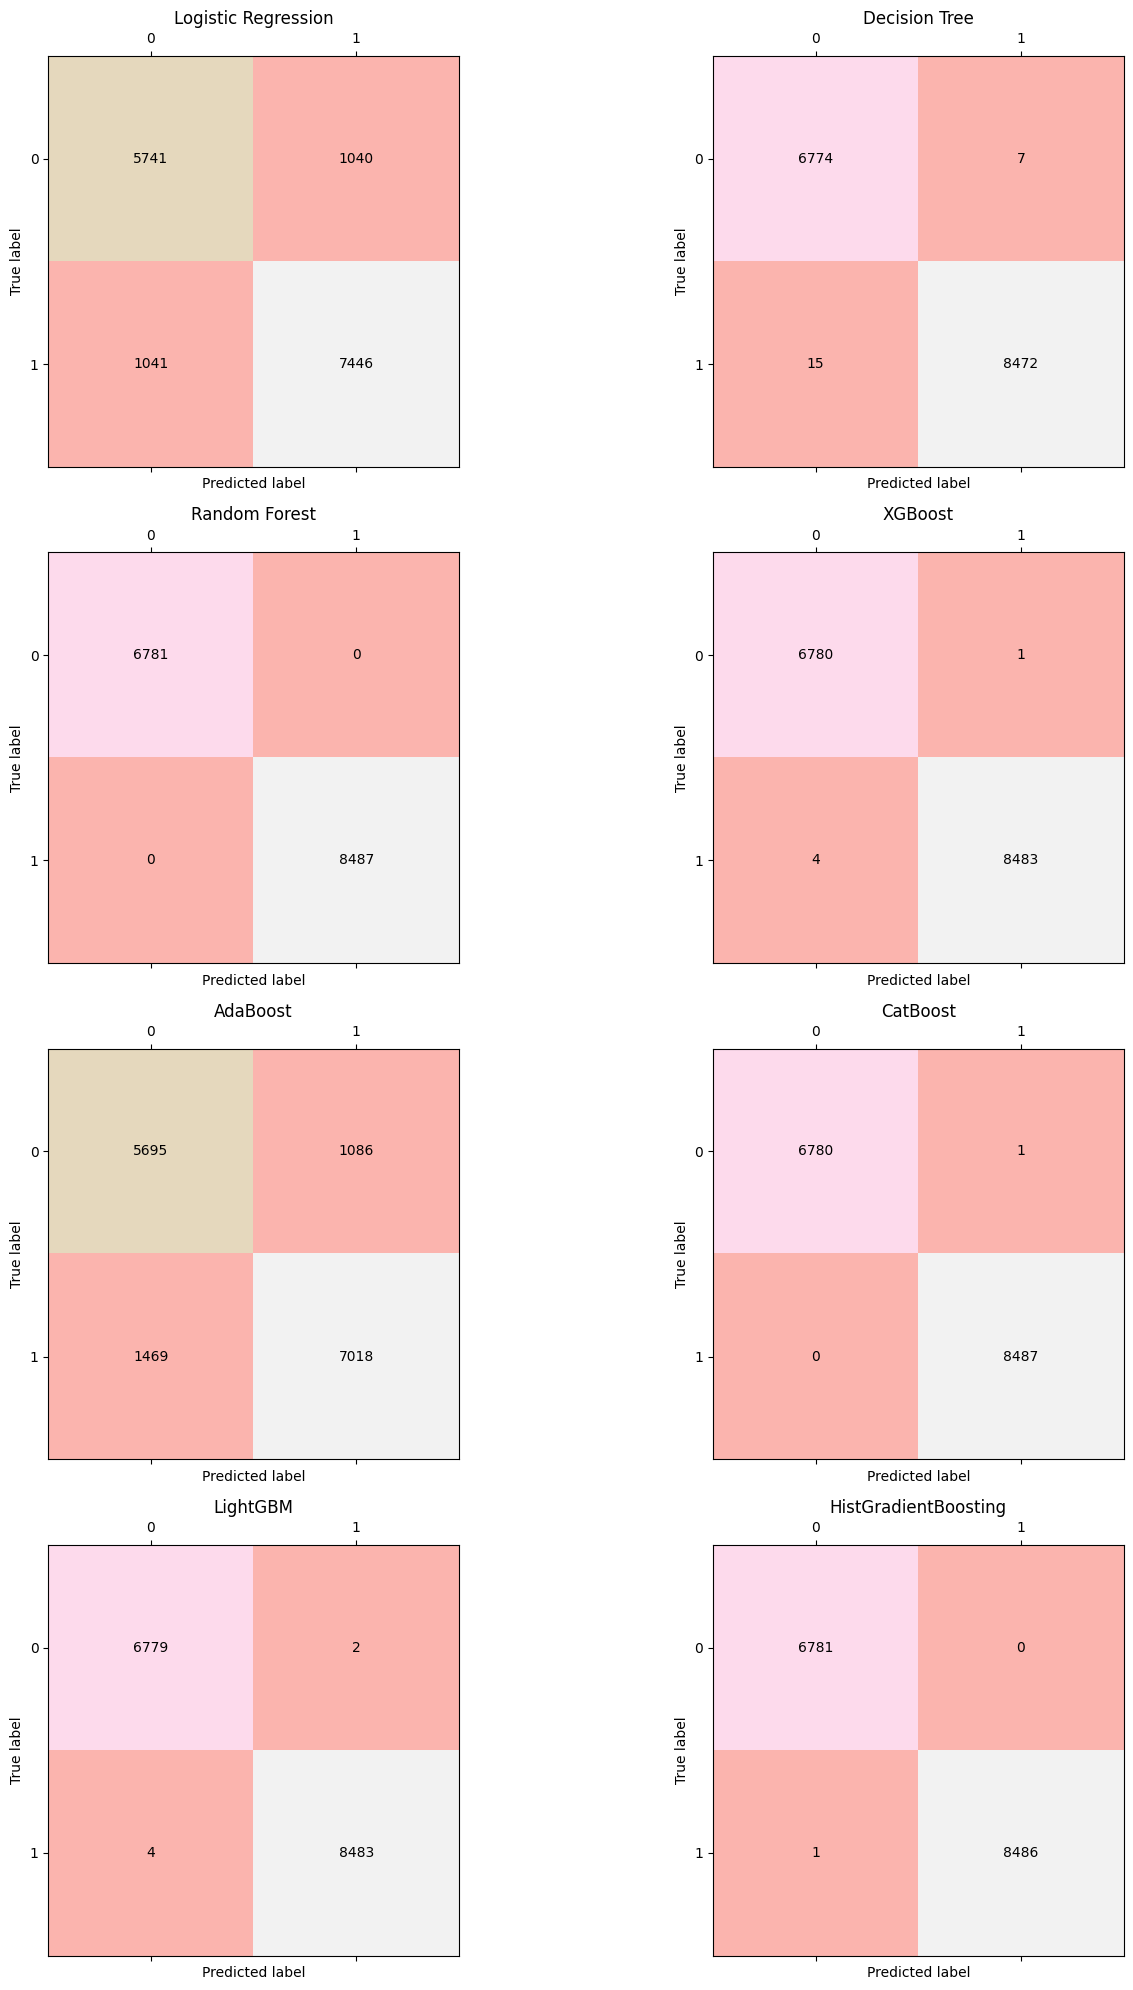

In [46]:
pipe.plot_confusion_matrix()

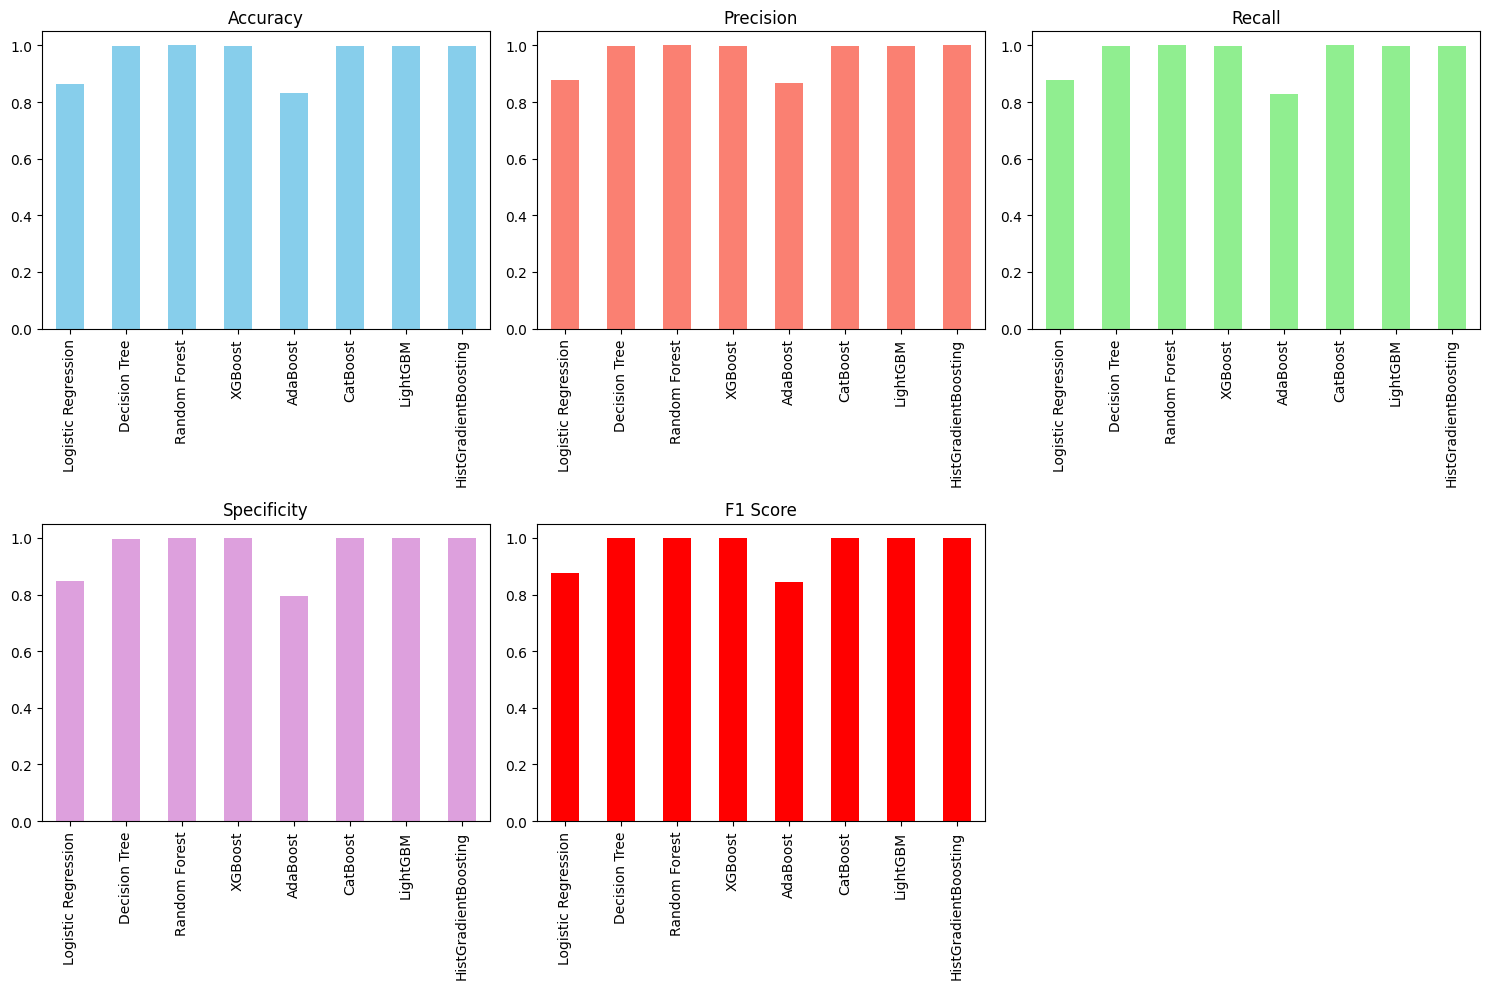

In [28]:
# Metrics Plot
pipe.plot_metrics()

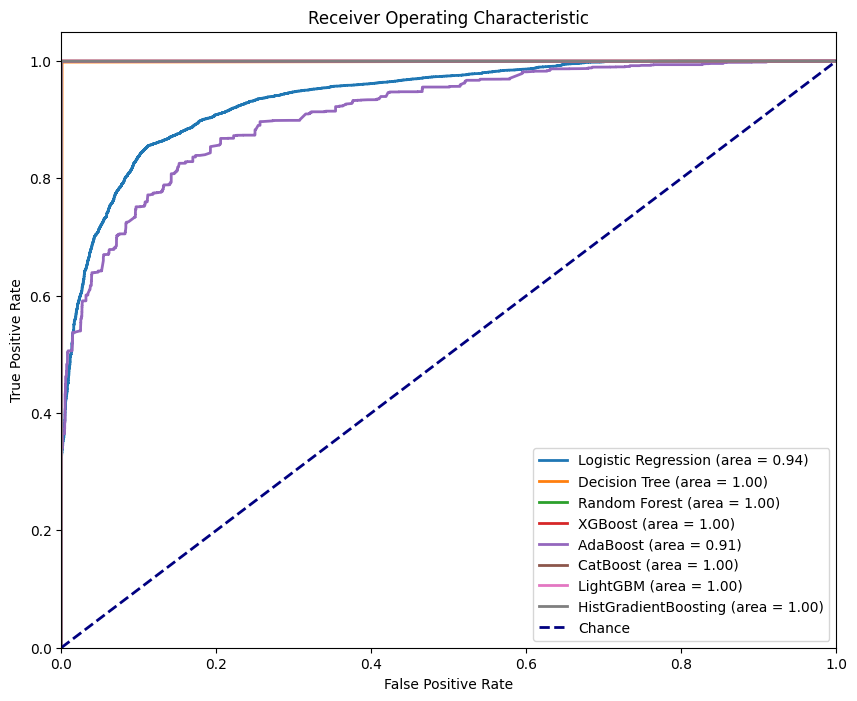

In [29]:
# ROC Plot
pipe.plot_roc()

## Feature Selection

In [24]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, \
                            recall_score
import numpy as np
from time import time

# New import
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel


In [26]:
feature_names = processed_df.columns.tolist()
feature_names


['cap-diameter',
 'stem-height',
 'stem-width',
 'class_e',
 'class_p',
 'cap-shape_b',
 'cap-shape_c',
 'cap-shape_f',
 'cap-shape_o',
 'cap-shape_p',
 'cap-shape_s',
 'cap-shape_x',
 'cap-surface_d',
 'cap-surface_e',
 'cap-surface_g',
 'cap-surface_h',
 'cap-surface_i',
 'cap-surface_k',
 'cap-surface_l',
 'cap-surface_s',
 'cap-surface_t',
 'cap-surface_w',
 'cap-surface_y',
 'cap-color_b',
 'cap-color_e',
 'cap-color_g',
 'cap-color_k',
 'cap-color_l',
 'cap-color_n',
 'cap-color_o',
 'cap-color_p',
 'cap-color_r',
 'cap-color_u',
 'cap-color_w',
 'cap-color_y',
 'does-bruise-or-bleed_f',
 'does-bruise-or-bleed_t',
 'gill-attachment_a',
 'gill-attachment_d',
 'gill-attachment_e',
 'gill-attachment_f',
 'gill-attachment_p',
 'gill-attachment_s',
 'gill-attachment_x',
 'gill-spacing_c',
 'gill-spacing_d',
 'gill-spacing_f',
 'gill-color_b',
 'gill-color_e',
 'gill-color_f',
 'gill-color_g',
 'gill-color_k',
 'gill-color_n',
 'gill-color_o',
 'gill-color_p',
 'gill-color_r',
 'gill-c

In [47]:
def fit_train(X_train, X_validate, y_train, y_validate,
              name,
              feature_selection_runtime="N/A",
              model=RandomForestClassifier(random_state=42)
              ):

     model.fit(X_train, y_train)

     y_pred_train = model.predict(X_train)
     y_pred_val = model.predict(X_validate)



     return pd.DataFrame({
          'Accuracy (training)': np.mean(y_pred_train == y_train).round(4),
          'Accuracy (validation)': np.mean(y_pred_val == y_validate).round(4),
          'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro').round(4),
          'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro').round(4),
          'features': ", ".join(X_train.columns.tolist()),
          'feature_selection_runtime': feature_selection_runtime

          }, index=[name]
)

In [51]:

experiment_results_df = fit_train(X_train=X_train,
          X_validate=X_test,
          y_train=y_train,
          y_validate=y_test,
          name=f"RandomForestClassifier - all features ({len(X.columns)})")


experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
RandomForestClassifier - all features (119),1.0,1.0,1.0,1.0,"cap-diameter, stem-height, stem-width, cap-sha...",N/A


## Create a Feature selector - if the model is so good can we drop a whole load of information?

In [52]:
model = RandomForestClassifier(random_state=42)

start_time = time()

sfs_forward = SequentialFeatureSelector(
    model, n_features_to_select=3, direction="forward"
)

sfs_forward.fit(X_train, y_train)

duration = time() - start_time

sfs_forward

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=3)

## look at the outputs



In [54]:
sfs_forward.get_support()

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [60]:
feature_names_selected_ff = X.columns[sfs_forward.get_support()].tolist()

feature_names_selected_ff

['stem-width', 'gill-attachment_p', 'stem-color_w']

In [62]:
experiment_results_df = pd.concat([experiment_results_df,
    fit_train(X_train=X_train[feature_names_selected_ff],
          X_validate=X_test[feature_names_selected_ff],
          y_train=y_train,
          y_validate=y_test,
          feature_selection_runtime=f"{duration:.3f}s",
          name="Forward Feature Selection - 3")]
)

experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
RandomForestClassifier - all features (119),1.0000,1.0000,1.0000,1.0000,"cap-diameter, stem-height, stem-width, cap-sha...",N/A
Forward Feature Selection - 3,0.7604,0.6676,0.6655,0.6572,"stem-width, gill-attachment_p, stem-color_w",440.511s


## try 5 parameters

In [63]:
model = RandomForestClassifier(random_state=42)

start_time = time()

sfs_forward = SequentialFeatureSelector(
    model, n_features_to_select=5, direction="forward"
)

sfs_forward.fit(X_train, y_train)

duration = time() - start_time

sfs_forward

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=5)

In [ ]:
feature_names_selected_ff = X.columns[sfs_forward.get_support()].tolist()

print(feature_names_selected_ff)


experiment_results_df = pd.concat([experiment_results_df,
    fit_train(X_train=X_train[feature_names_selected_ff],
          X_validate=X_test[feature_names_selected_ff],
          y_train=y_train,
          y_validate=y_test,
          feature_selection_runtime=f"{duration:.3f}s",
          name="Forward Feature Selection - 5")]
)

experiment_results_df